## Exploring Clinical Computational Cancer Genomics Data 


<span style="font-size: 16px;">
    <b>Author - Sanmati Dugad </b><br>
    <b> Derived Data - Dana Farber Cancer Institute, Boston, MA </b><br>

In [1]:
rm(list=ls()) 
setwd("/home/data/mafs/")


In [3]:

library(dplyr)
library(ggplot2)
library(reshape2)
library(ggrepel)
library(ggtext)

options(scipen = 999)

### Question 1

1. Read and Merge the Mutation Annotation Format (MAF) files. Each of these 50 files contains the genomic mutations observed in a different patient’s tumor, obtained by biopsy and sequenced with whole-exome sequencing. Each row in a MAF file corresponds to a different mutation.

In [4]:
# list all maf files in the directory
maf_files = list.files(pattern = "\\.maf$", full.names = TRUE)

# Read and merge MAF files
merged_maf = bind_rows(lapply(maf_files, function(file) {
  maf_data = read.csv(file, sep = "\t", header = TRUE, stringsAsFactors = FALSE)
  maf_data$Chromosome = as.character(maf_data$Chromosome)  # Convert Chromosome to character
  maf_data = data.frame(sapply(maf_data, trimws))    # Remove leading and trailing spaces from values.
  return(maf_data)
}))

# Write the merged MAF file to a new file
write.table(merged_maf, file = "merged_maf_files.tsv", sep = "\t", quote = FALSE, row.names = FALSE)

head(merged_maf)

,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,AMOT,X,112035152,112035152,Missense_Mutation,SNP,G,G,C,Patient-0-Tumor,Patient-0-Normal,p.Q612E,8,31
2,SEMA6D,15,48062786,48062786,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.A676T,4,87
3,PRR12,19,50100969,50100969,Missense_Mutation,SNP,C,C,G,Patient-0-Tumor,Patient-0-Normal,p.S1126C,5,25
4,TNR,1,175372529,175372529,Silent,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.S241S,30,155
5,CPA4,7,129944344,129944344,Silent,SNP,C,C,G,Patient-0-Tumor,Patient-0-Normal,p.A137A,12,100
6,SLC35E2B,1,1607589,1607589,Silent,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.L124L,5,29


### Question 2

2. Subset for mutations that are not of the Variant Classification “Silent”. For the purposes of this analysis, we will restrict ourselves to substitutions which result in changes to the produced protein (“nonsynonymous mutations”).

In [5]:
# Subset for mutations that are not of the Variant Classification “Silent”.
filtered_maf = filter(merged_maf, Variant_Classification != "Silent")
head(filtered_maf)

,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,AMOT,X,112035152,112035152,Missense_Mutation,SNP,G,G,C,Patient-0-Tumor,Patient-0-Normal,p.Q612E,8,31
2,SEMA6D,15,48062786,48062786,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.A676T,4,87
3,PRR12,19,50100969,50100969,Missense_Mutation,SNP,C,C,G,Patient-0-Tumor,Patient-0-Normal,p.S1126C,5,25
4,ZNF253,19,20002885,20002885,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.V277I,6,66
5,MEF2C,5,88025061,88025061,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.S313L,6,42
6,TTN,2,179613803,179613803,Nonsense_Mutation,SNP,C,C,A,Patient-0-Tumor,Patient-0-Normal,p.E4442*,4,55


<span style="font-size: 16px;">
<b> Answer 2. </b><br>
A total of “4426” Silent mutations were excluded from the data for further analysis

### Question 3

3. Find the 15 most common mutations. Gene names are included in the column Hugo_Symbol and protein changes are stored in the column Protein_Change.

In [6]:
# Group by Hugo_Symbol and Protein_Change, count occurrences, and arrange in descending order
mutation_counts <- filtered_maf %>%
  group_by(Hugo_Symbol, Protein_Change) %>%
  summarize(count = n(), .groups = 'drop') %>%
  arrange(desc(count))

# Select the top 15 most common mutations
top_mutations = head(mutation_counts, 15)
top_mutations

Hugo_Symbol,Protein_Change,count
<chr>,<chr>,<int>
ERBB4,p.S1289A,14
ERBB3,p.H228Q,5
ERBB4,p.Q707E,5
PIK3CA,p.E545K,5
ERBB3,p.M91I,4
ERBB4,p.E317K,4
FAM47C,p.Q225E,4
KRTAP4-11,p.L161V,4
MAP2K1,p.F53L,4


<span style="font-size: 16px;">
<b> Answer 3. </b><br>
a. The most frequently occurring mutation is in the gene ERBB4 with the protein change
p.S1289A, having a count of 14.

### Question 4

4. Perform a statistical test to explore if any mutated genes are enriched in patients who either responded or not. Response labels for individual patients are found in the file sample-information.tsv.

In [7]:
sample_info = read.csv("/home/data/sample-information.tsv", header = TRUE, sep = "\t")

# Merge the mutation data with the sample information
merged_data = merge(filtered_maf, sample_info, by = "Tumor_Sample_Barcode", all = TRUE)
merged_data.1 = merge(merged_maf, sample_info, by = "Tumor_Sample_Barcode", all = TRUE)

# Since we have small sample sizes, I chose to Perform Fisher's exact test.
contingency_table <- table(merged_data$Hugo_Symbol, merged_data$Response)

# Initialize an empty vector for p-values
p_values <- numeric(0)

# Iterate over each row in the contingency table
for (row_name in rownames(contingency_table)) {
  # Check if the row name is present
  if (row_name %in% rownames(contingency_table)) {
    # Print counts for the current row in specific categories
    counts_row <- contingency_table[row_name, c("Non-Responder", "Responder")]
    a <- counts_row[1]
    b <- counts_row[2]
    
    # Create a 2x2 matrix
    row_matrix <- matrix(c(a, b, b, a), nrow = 2, ncol = 2)
    
    # Perform Fisher's exact test
    fisher_test_result <- fisher.test(row_matrix)
    
    # Append the p-value to the p_values vector
    p_values <- append(p_values, fisher_test_result$p.value)
  }
}

print(paste("The number of P_values < 0.05 are: ", table(p_values < 0.05)[2]))

# Reformatting the data to append the generated P_values
contingency_table = as.data.frame(contingency_table)
contingency_table.1 =  reshape2::dcast(contingency_table, Var1 ~ Var2, value.var = "Freq")
contingency_table.1$P_values = p_values

#unique(contingency_table.enriched$P_values)

# Identifying enriched mutated genes by setting a P-value threshold of 0.05
contingency_table.enriched <- filter(contingency_table.1, P_values < 0.05)
colnames(contingency_table.enriched)[1] = "Hugo_Symbol"

print(head(contingency_table.enriched[order(contingency_table.enriched$P_values), ]))

# We Identify 96 mutated genes to be enriched in patients who either responded or not. (P < 0.05)

[1] "The number of P_values < 0.05 are:  96"
   Hugo_Symbol Non-Responder Responder          P_values
50       KMT2C             1        19 0.000000005818065
5        AKAP9             0         9 0.000041135335253
7         ANK2             0         9 0.000041135335253
30       ERCC2             0         9 0.000041135335253
51        KRT4             0         9 0.000041135335253
39       HERC1             0         8 0.000155400155400


<span style="font-size: 16px;">
    <b>Answer 4.</b><br>
 1. Fisher's exact test was performed since the data contains small sample sizes <br>
 2. We Identify 96 mutated genes to be enriched in patients who either responded or not. (P < 0.05) <br>
 3. “KMT2C” gene was identified with the least P-values. Dataframe above is sorted according to their
P-values
</span>

### Question 5

5. Create a scatter plot of genes with the number of mutated patients on the x-axis and your results from question 4 on the y-axis. Can the figure in any way to improve readability? If so, recreate the plot using your suggestion(s).

In [ ]:
# scatter plot of genes with the number of mutated patients on the x-axis
# and P-values generated from question 4 on Y-axis
plot((contingency_table.enriched$`Non-Responder` + contingency_table.enriched$Responder),
     -log10(contingency_table.enriched$P_values),
     main = "Scatterplot of statistically significant mutated genes",
     xlab = "Number of Mutated Patients", ylab = "-log10(P_Values",
     col = "#6406B6", pch = 16, cex= 1.2)

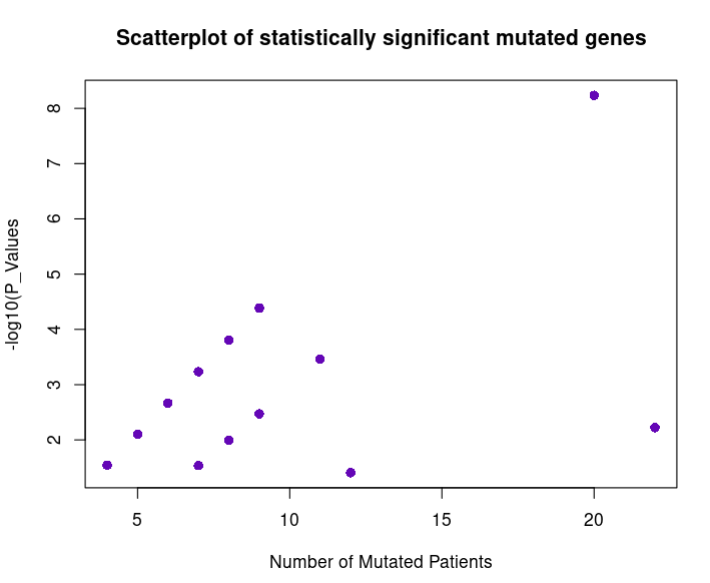

<span style="font-size: 16px;">
    <b>Answer 5.</b><br>
1. We see multiple data points missing from the above scatter plot due to the overlapping
of identical points.  <br>
2. To improve readability, we can recreate the plot using ggplot. <br>
3. In ggplot2 we can jitter the points and add some noise to the overlapping points. <br>
4. Also labelled the mutant genes having highest number of responders and non-responders. <br>
</span>

In [ ]:
ggplot(contingency_table.enriched,
       aes(x = `Non-Responder` + Responder, y = -log10(P_values))) +
  geom_point(position = position_jitter(height = 0.1, width = 0), alpha = 0.5, size = 3, aes(col = Responder)) + # Adding jitter
  #facet_wrap(contingency_table.enriched$Responder) +
  geom_text_repel(data = subset(contingency_table.enriched, `Non-Responder` + Responder > 10),
                  aes(label = Hugo_Symbol), box.padding = 0.5, point.padding = 0.5, size = 3, family = "bold") +  # Add repelling labels for x > 10
  labs(title = "Scatterplot of statistically significant mutated genes",
       x = "Number of Mutated Patients",
       y = "-log10(P_Values") +
  theme_bw()

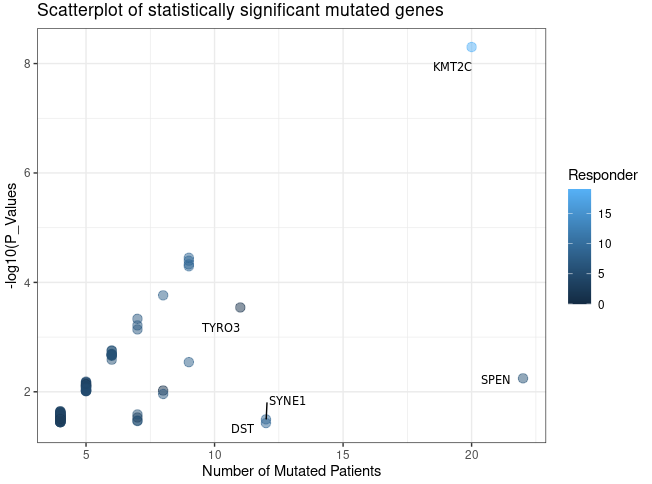

### Question 6

6. How many samples are wild-type versus mutant with respect to the most significantly enriched gene from Question 4? Plot the number of nonsynonymous mutations per megabase in the mutant vs. wild-type samples. Is there a significant difference in the number of mutations between the two groups? Information on the number of nonsynonymous mutations per megabase for each patient can be found in the file data/sample-information.tsv.

In [9]:
# Number of wild-type (Non-responders) versus mutant (responders) with respect to the most significantly enriched gene.
# For the most enriched gene (mutant gene with the lowest P-value)
most_enriched_gene <- contingency_table.enriched[which.min(contingency_table.enriched$P_values), ]

# Renamed Non-Responder and Responder
colnames(most_enriched_gene)[2] = "Wild_type Samples"
colnames(most_enriched_gene)[3] = "Mutant Samples"
rownames(most_enriched_gene)[1] = "Most_enriched_gene"
print(t(most_enriched_gene))

                  Most_enriched_gene 
Hugo_Symbol       "KMT2C"            
Wild_type Samples "1"                
Mutant Samples    "19"               
P_values          "0.000000005818065"


In [ ]:
# Plot the number of nonsynonymous mutations per megabase in the mutant vs. wild-type samples.
boxplot(Nonsynonymous_mutations_per_Mb ~ Response, data = sample_info, col = "wheat",
        xlab = substitute(paste(bold("Response"))), 
        ylab = substitute(paste(bold("Nonsynonymous_mutations_per_Mb"))),
        main = "Comparison of nonsynonymous mutations per megabase between \n responders v/s non-responders",
        outcol = "chocolate1", outcex = 1.2, outpch = 21 , outbg = "yellow")

  # Create x-coordinates for points
x_non_responder <- jitter(rep(1, sum(sample_info$Response == "Non-Responder")), amount = 0.15)
x_responder <- jitter(rep(2, sum(sample_info$Response == "Responder")), amount = 0.15)

  # Add points
points(x_non_responder, sample_info$Nonsynonymous_mutations_per_Mb[sample_info$Response == "Non-Responder"], col="darkblue",bg = "#0972D5",pch = 21, cex = 1.2)
points(x_responder, sample_info$Nonsynonymous_mutations_per_Mb[sample_info$Response == "Responder"], col = "darkblue", bg = "#0972D5",pch = 21, cex = 1.2)




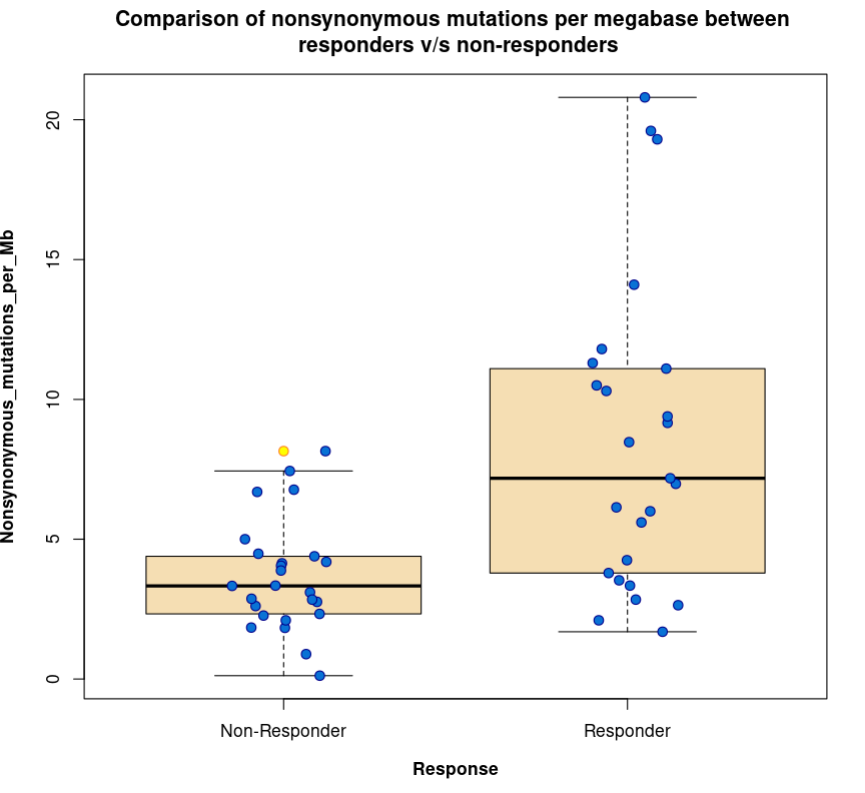

<span style="font-size: 16px;">
    <b>Answer 6.</b><br>
Wilcoxon rank-sum test was performed to assess the statistical significant difference in the number of mutations between the two groups. <br>
<br>
a. The P-value calculated using the Wilcoxon test is < 0.05. <br>
b. Hence we can say that there lies a statistically significant difference in the number of mutations between the two groups. <br>
(P = 0.00049 - two.sided)


In [10]:
Responders = sample_info$Nonsynonymous_mutations_per_Mb[sample_info$Response == "Responder"]
Non_Responders = sample_info$Nonsynonymous_mutations_per_Mb[sample_info$Response == "Non-Responder"]

# Perform Wilcoxon rank-sum test
wilcox_result <- wilcox.test(Responders, Non_Responders, correct = TRUE, exact = FALSE)
print(paste("The P-value calculated using Wilcoxon two.sided rank test is ", round(wilcox_result$p.value, 7)))

# The P-value calculated using the Wilcoxon test is < 0.05.
# Hence we can say that there lies a statistically significant difference in the number of mutations in the two groups. (P = 0.00049 - two.sided)

summary(Responders)
summary(Non_Responders)

[1] "The P-value calculated using Wilcoxon two.sided rank test is  0.0004957"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.690   3.790   7.180   8.476  11.100  20.800 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.120   2.330   3.330   3.656   4.390   8.150 

### Question 7

7. Write any conclusions that you have made based on your analysis. How might this analysis be improved or expanded upon? Please include all requested figures in your report.

<span style="font-size: 16px;">
    <b>Answer 7.</b><br>

<b> Conclusion: </b> <br>
a. Number of Nonsynonymous_mutations_per_Mb in <b>Non-responders </b> ranges from 0.12 to 8.150, <b> Median: 3.33, Average: 3.65. </b> <br>
    b. Number of Nonsynonymous_mutations_per_Mb in <b> Responders </b> ranges from 1.69 to 20.800, <b> Median of 7.18, Average of 8.476. </b> <br>
c. Hence we observe an approximate <b> two-fold increase </b> of Nonsynonymous mutations  in the <b> Responders. </b><br>

<span style="font-size: 16px;">
To improve the analysis:

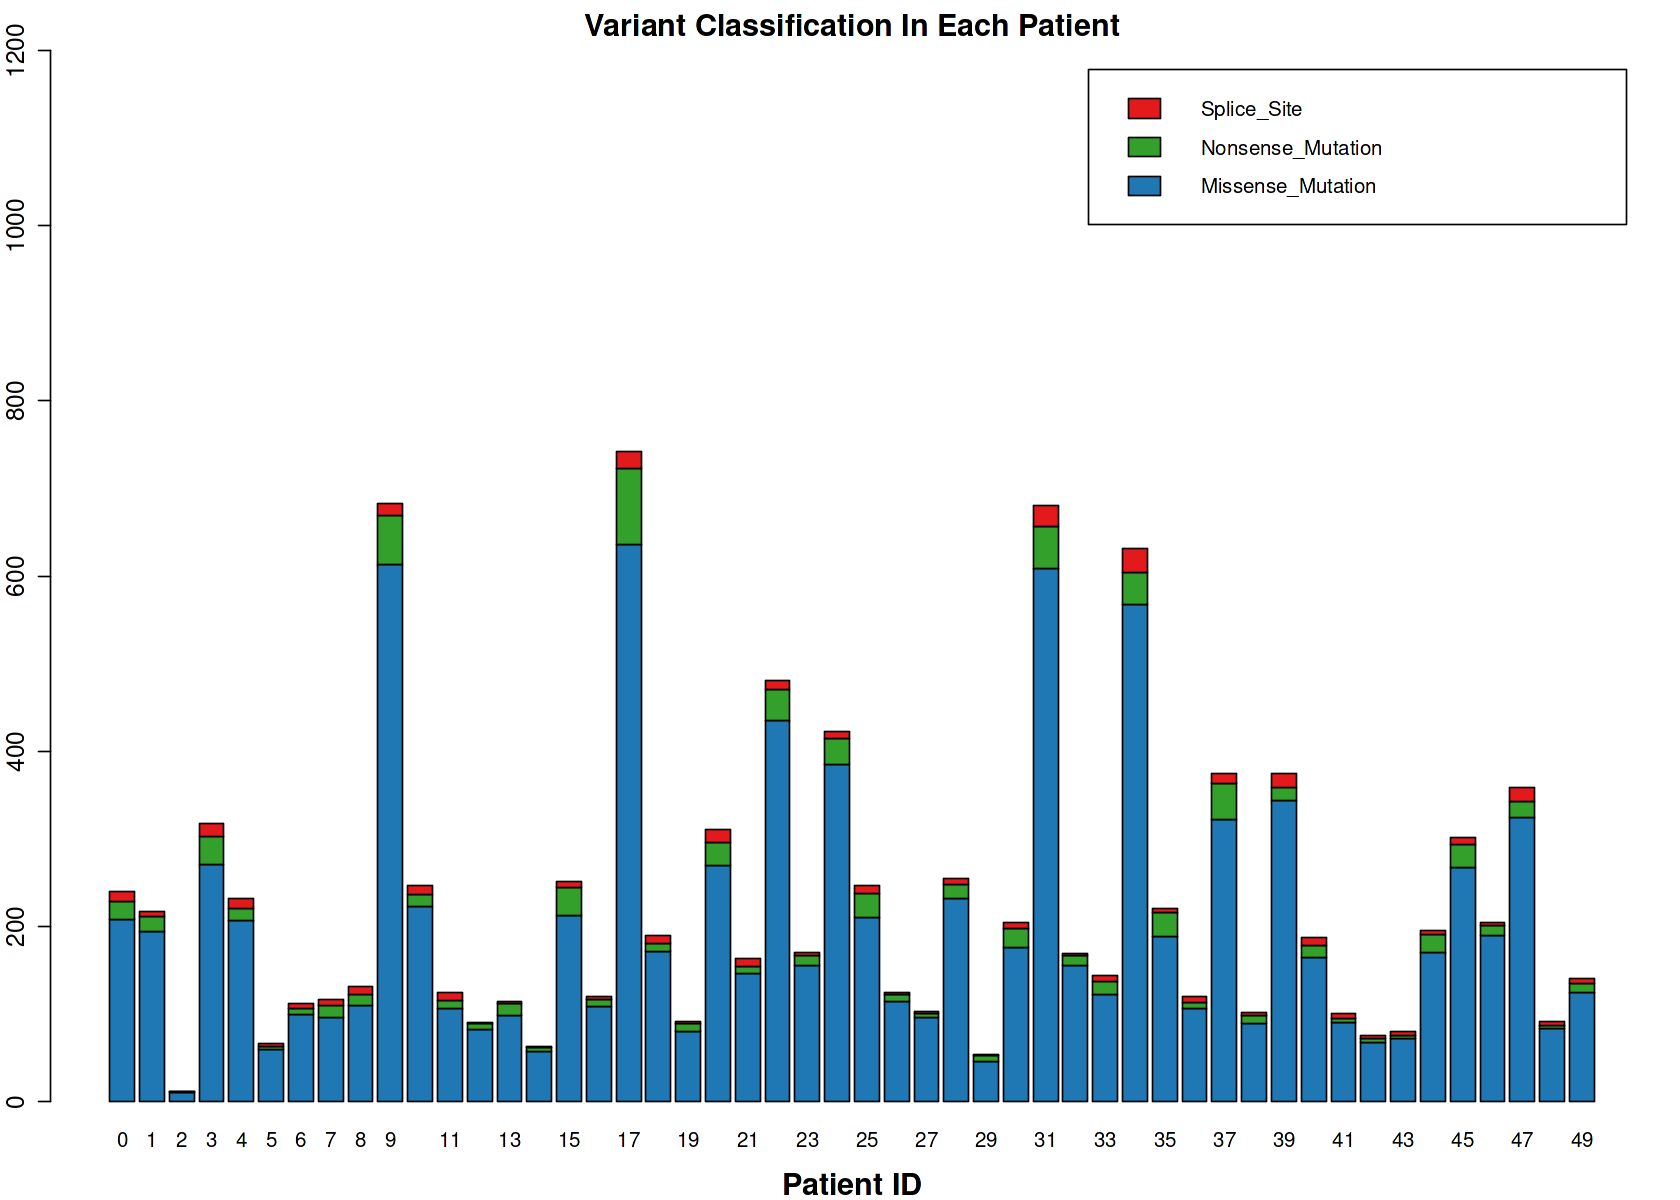

In [12]:
# 1. Barplot - Calculate the number of variants in each patient

  # make a counts table with the variant classification column
my_colors <- c("#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#a6cee3",
               "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99", "#b15928")

counts = table(merged_data$Variant_Classification, merged_data$Tumor_Sample_Barcode)
colnames(counts) = paste(0:49)

  # generate stacked barplot.
options(repr.plot.width = 14, repr.plot.height = 10)
par(mar = c(4, 2, 2, 1) + 0.1)
barplot(counts, main="Variant Classification In Each Patient",
        xlab=substitute(paste(bold("Patient ID"))),
        ylab = substitute(paste(bold("Number of mutations"))),
        col=my_colors, ylim = c(0,1200),
        legend = rownames(counts), 
        cex.axis = 1.2, cex.main = 1.5, cex.lab = 1.5)

# Observations:
# a. All patients have more number of missense mutations.
# b. Patient 2 had the least number of mutations with all missense mutations only.
# c. Patient 17 had the most number of mutations, followed by patient 31, patient 34 and patient 9 accordingly.


 A>C  A>G  A>T  C>A  C>G  C>T  G>A  G>C  G>T  T>A  T>C  T>G 
 160  461  146  529 1518 2751 2870 1582  526  170  409  125 

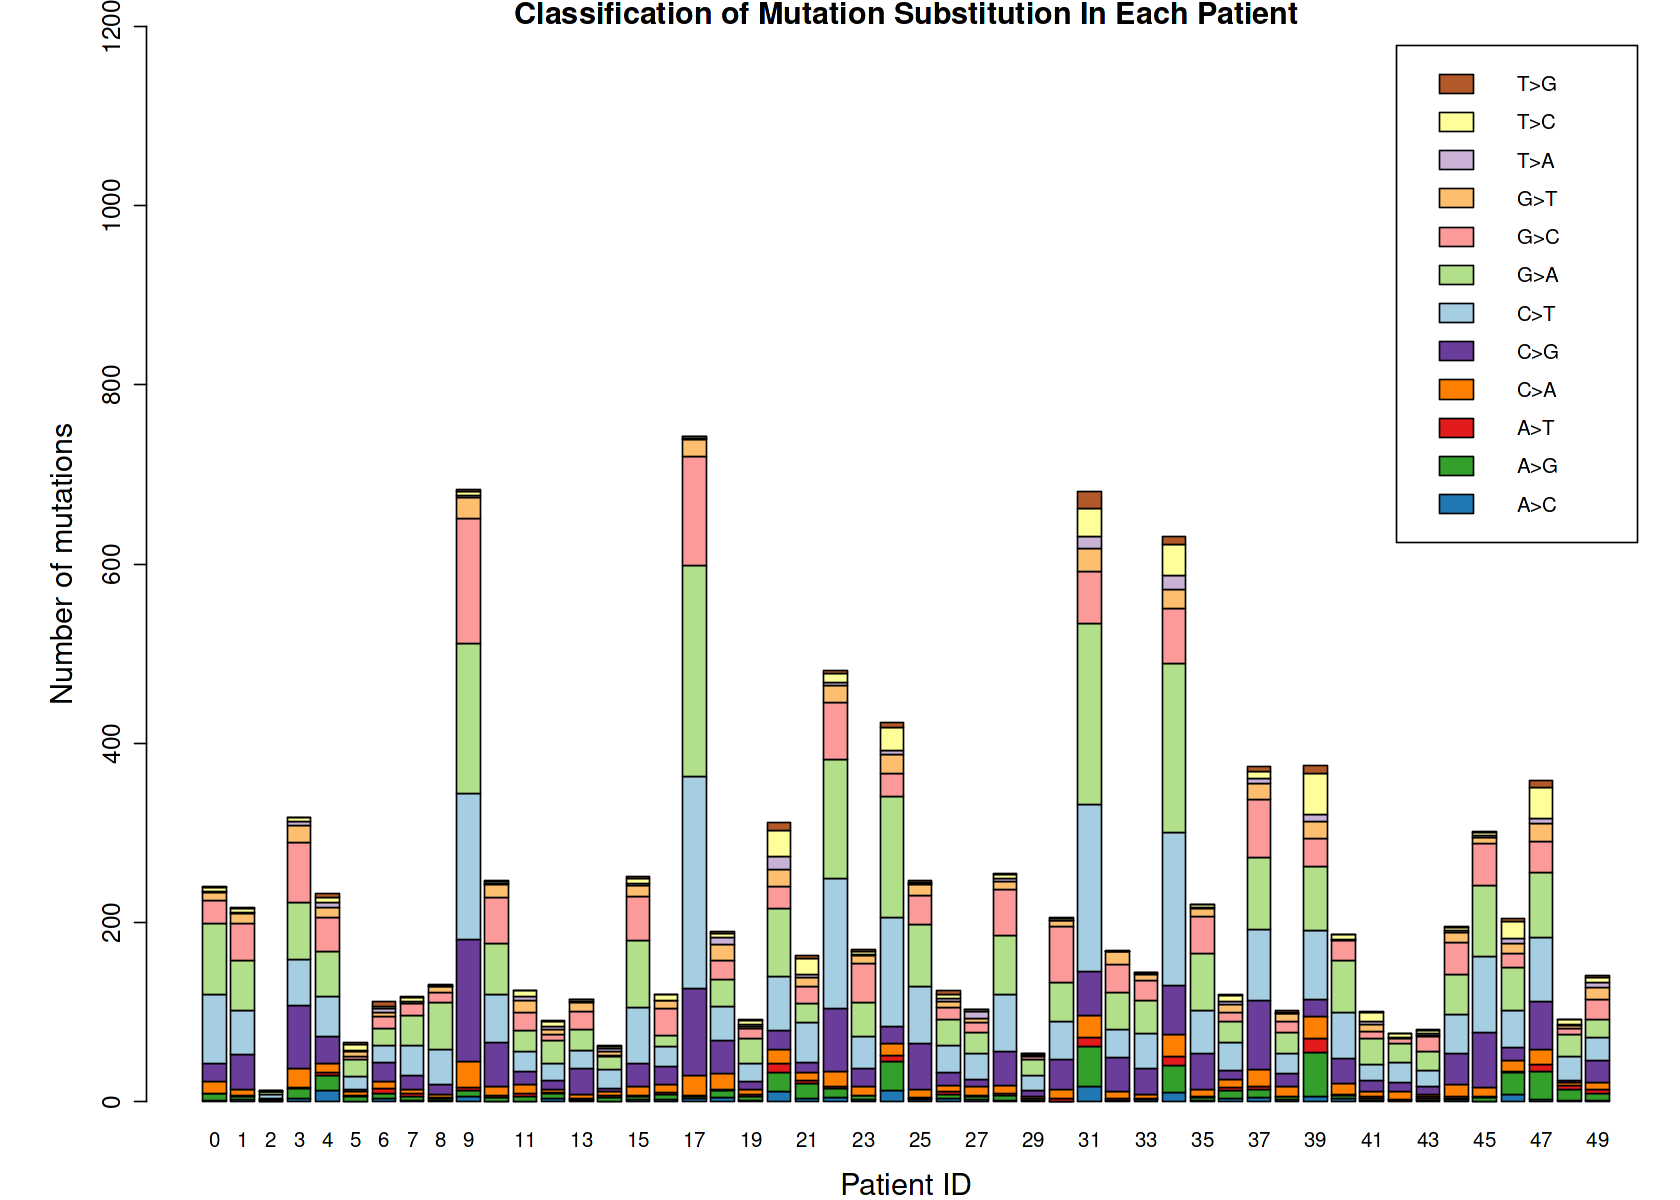

In [13]:
# 2. Barplot. Calculate the number of mutation substitution in each patient
  
  #Create a new comparison column of mutations.
merged_data.1 = merged_data
merged_data.1$comparison_column <- with(merged_data.1, ifelse(
  Reference_Allele != Tumor_Seq_Allele1 & Reference_Allele != Tumor_Seq_Allele2,
  paste(Reference_Allele, ">", Tumor_Seq_Allele1, "/", Tumor_Seq_Allele2, sep = ""),
  ifelse(Reference_Allele != Tumor_Seq_Allele1, paste(Reference_Allele, ">", Tumor_Seq_Allele1, sep = ""),
         ifelse(Reference_Allele != Tumor_Seq_Allele2, paste(Reference_Allele, ">", Tumor_Seq_Allele2, sep = ""), "")
  )
))

table(merged_data.1$comparison_column)
  # make a counts table with the comparison column
comparision_counts = table(merged_data.1$comparison_column, merged_data.1$Tumor_Sample_Barcode)
colnames(comparision_counts) = paste(0:49)
  # generate a stacked barplot.
options(repr.plot.width = 14, repr.plot.height = 10)
par(mar = c(4, 6, 1, 0.5) + 0.1)
barplot(comparision_counts, main="Classification of Mutation Substitution In Each Patient",
        xlab="Patient ID", ylab = "Number of mutations",
        col= my_colors, ylim = c(0,1200),
        legend = rownames(comparision_counts),
        cex.axis = 1.2, cex.main = 1.5, cex.lab = 1.5)

## Observations
# a. Almost all patients had the maximum amount of G>A mutation substitution.
# b. The seond most identified mutation in all patients was the C>T, followed by G>C and C>G
# c. A total of 2870 substitutions occured for G>A.
# d. The rarest substitution among the data was the T>G, with only 125 mutations.


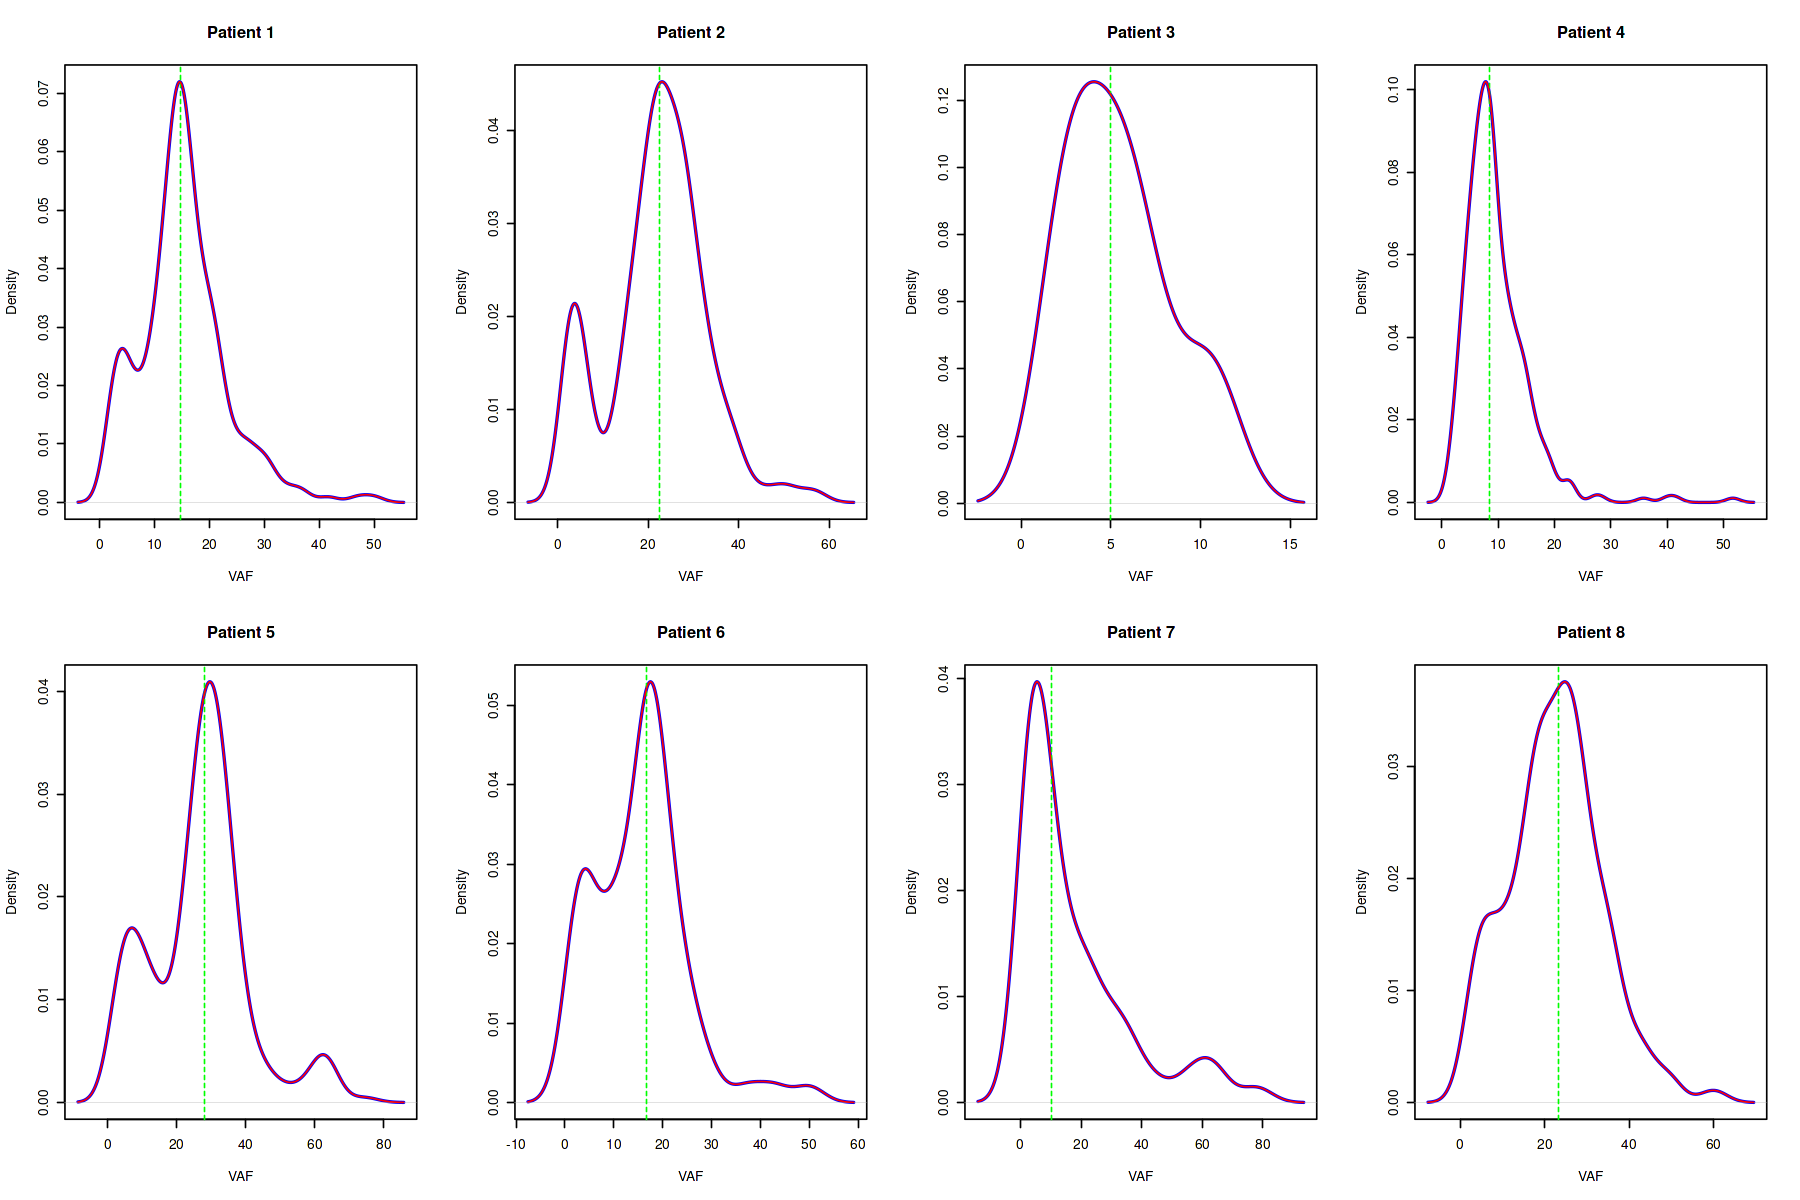

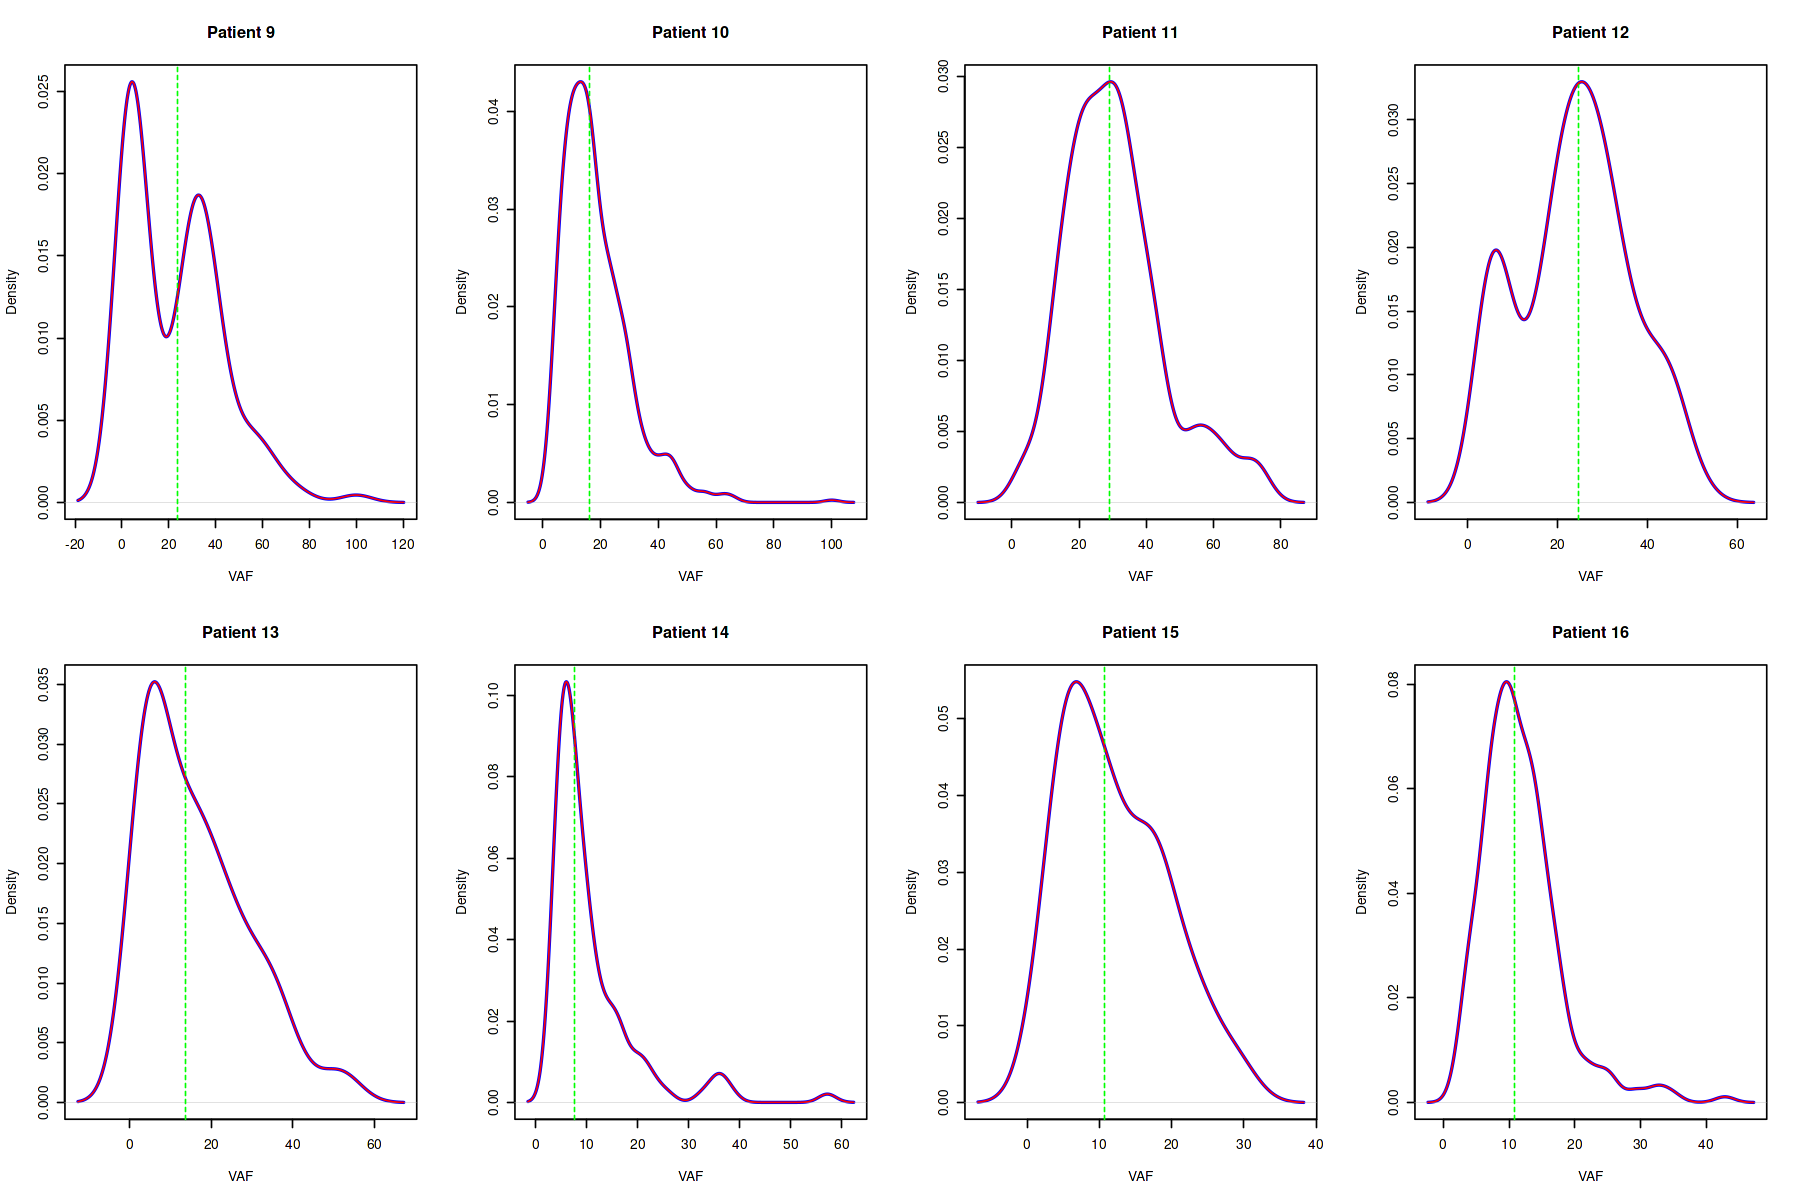

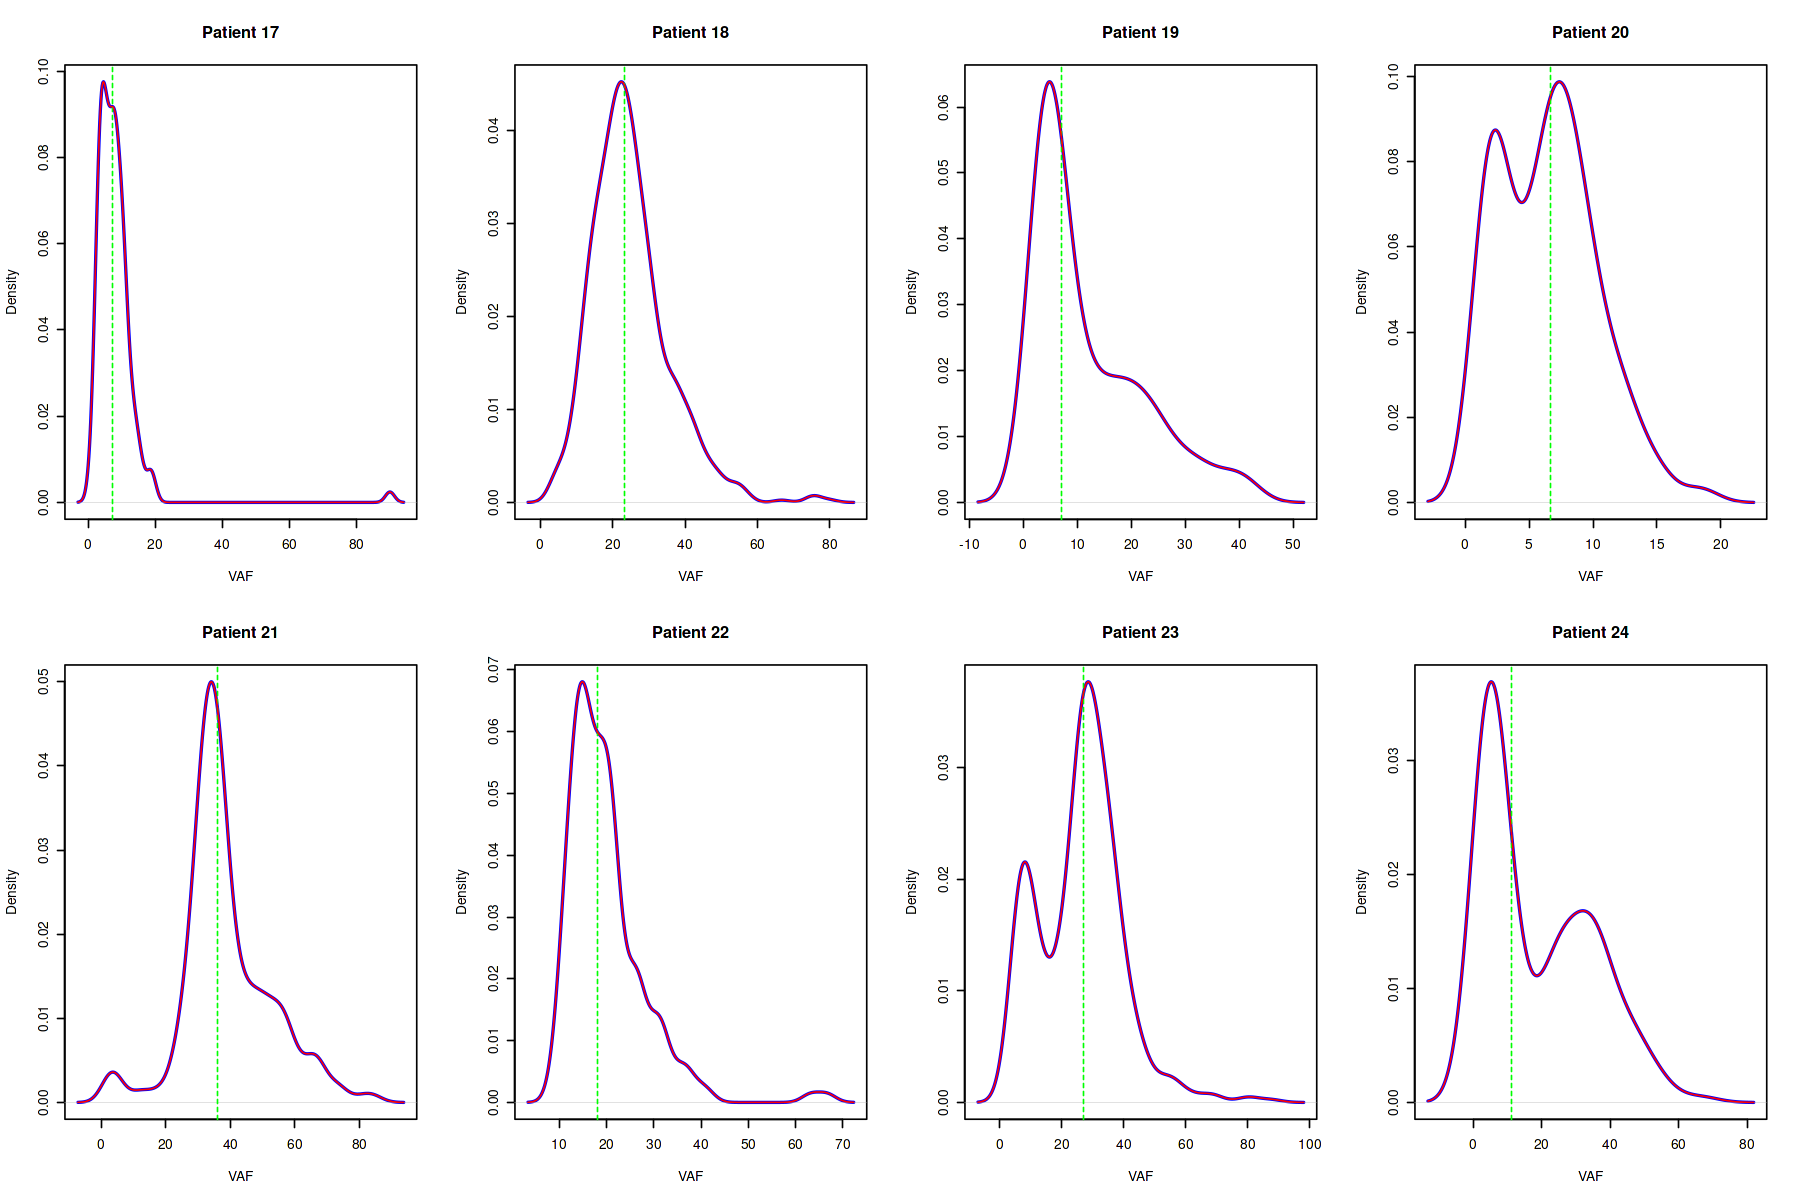

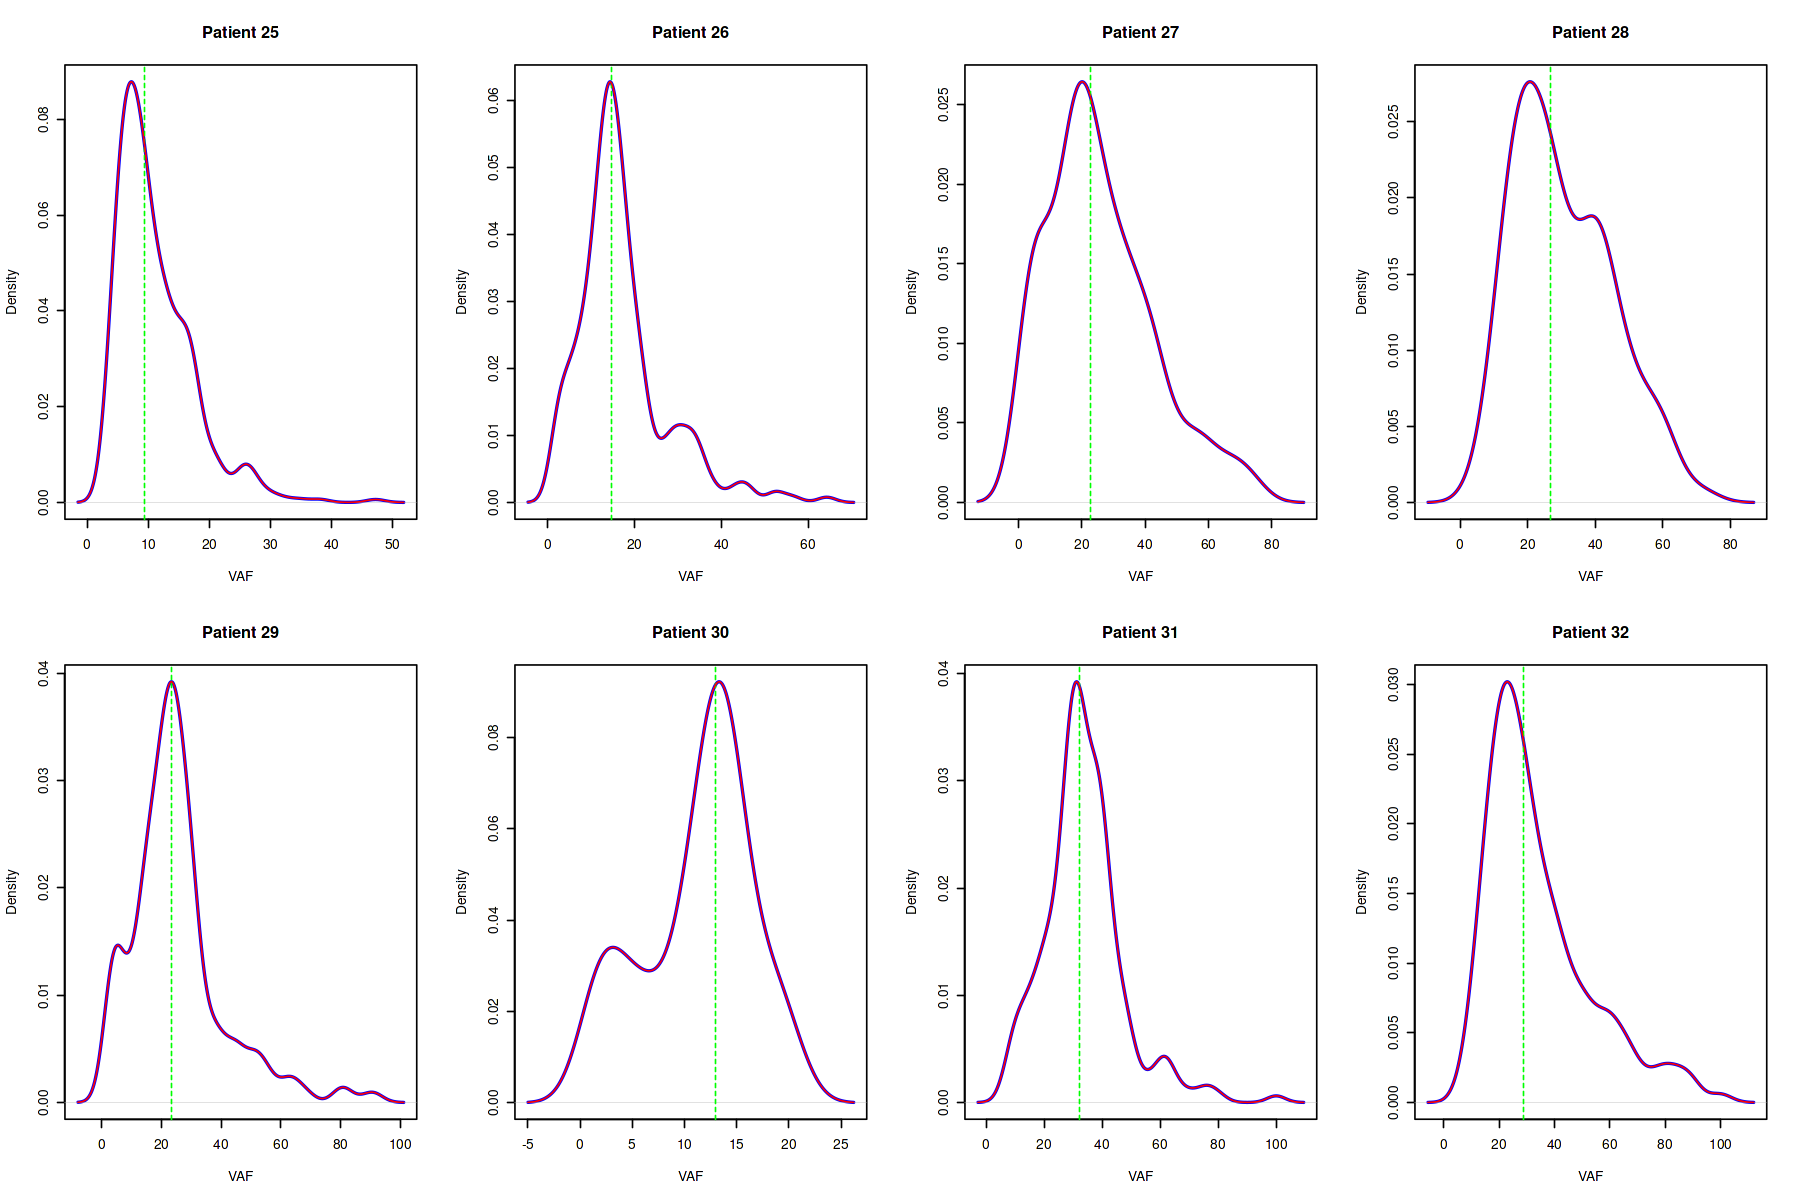

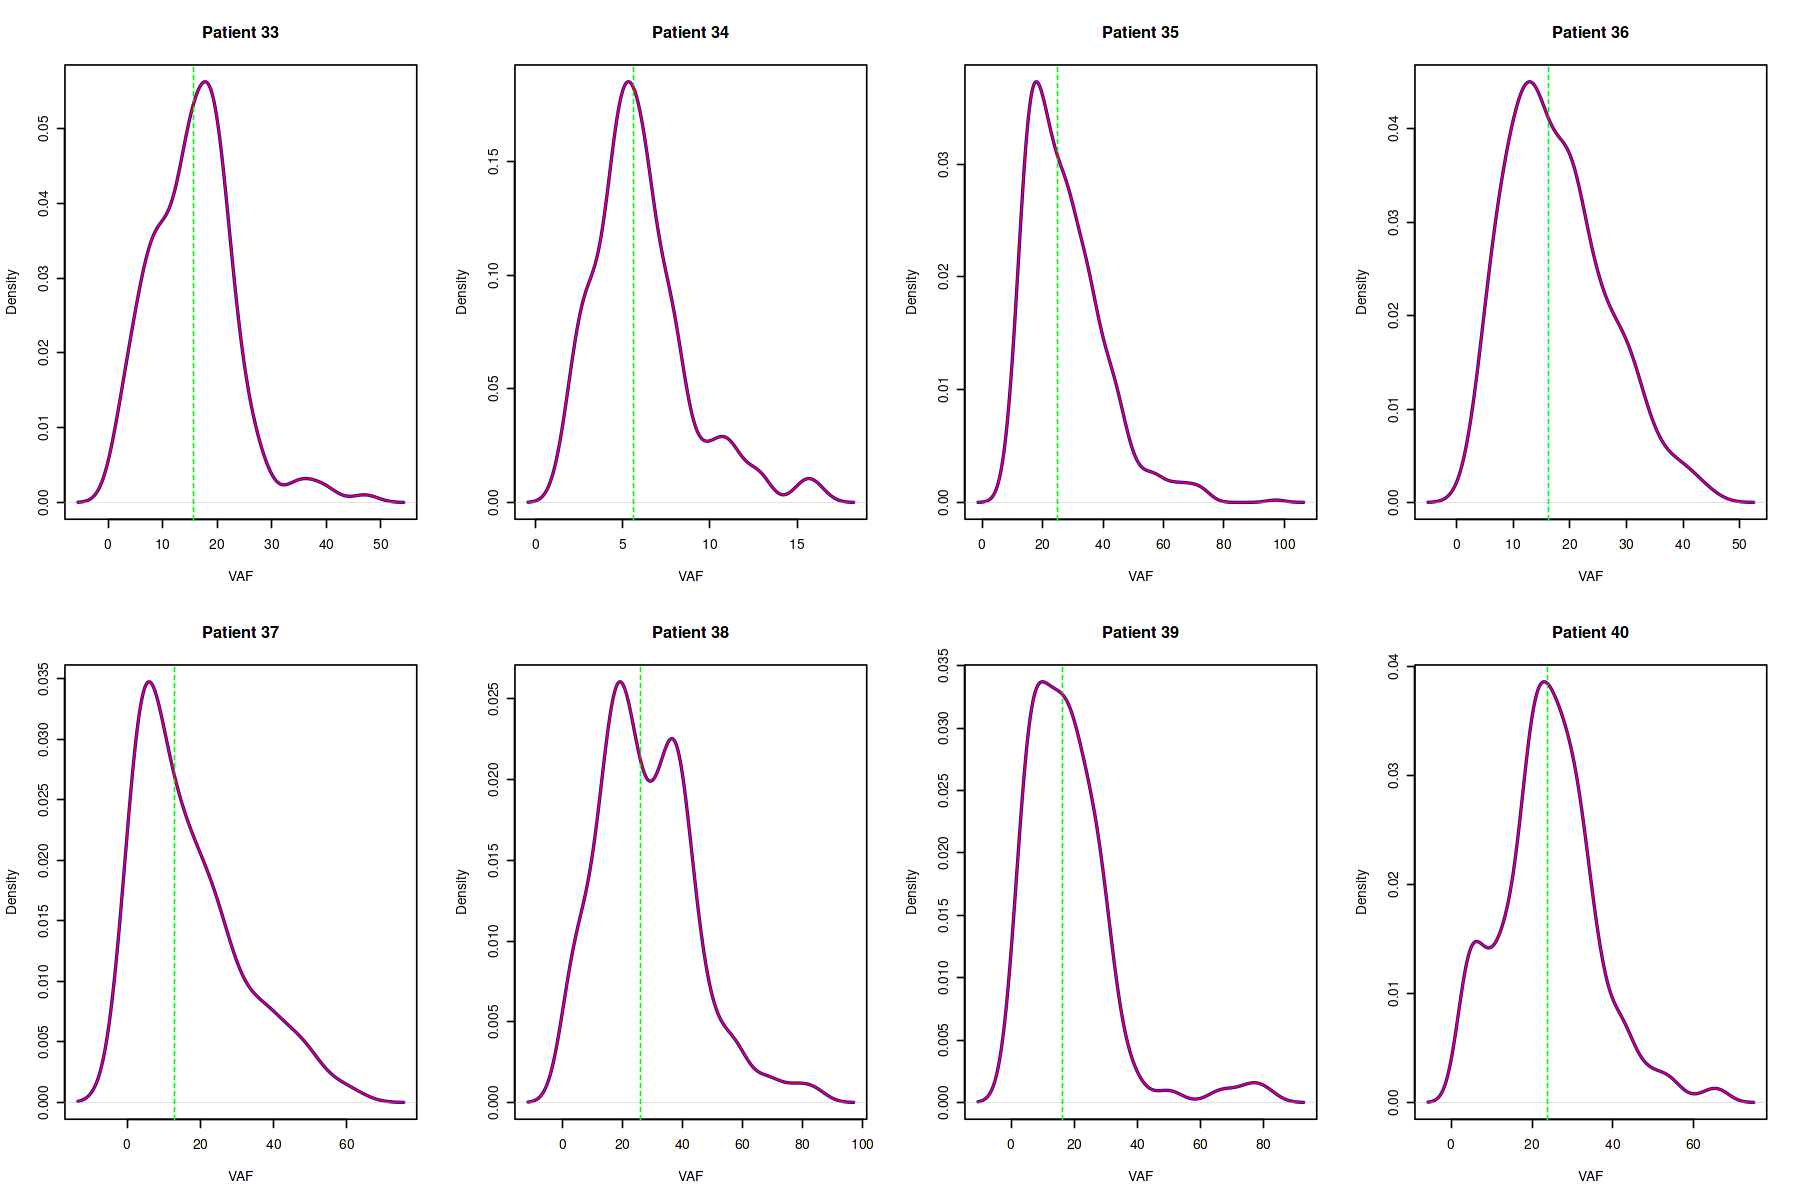

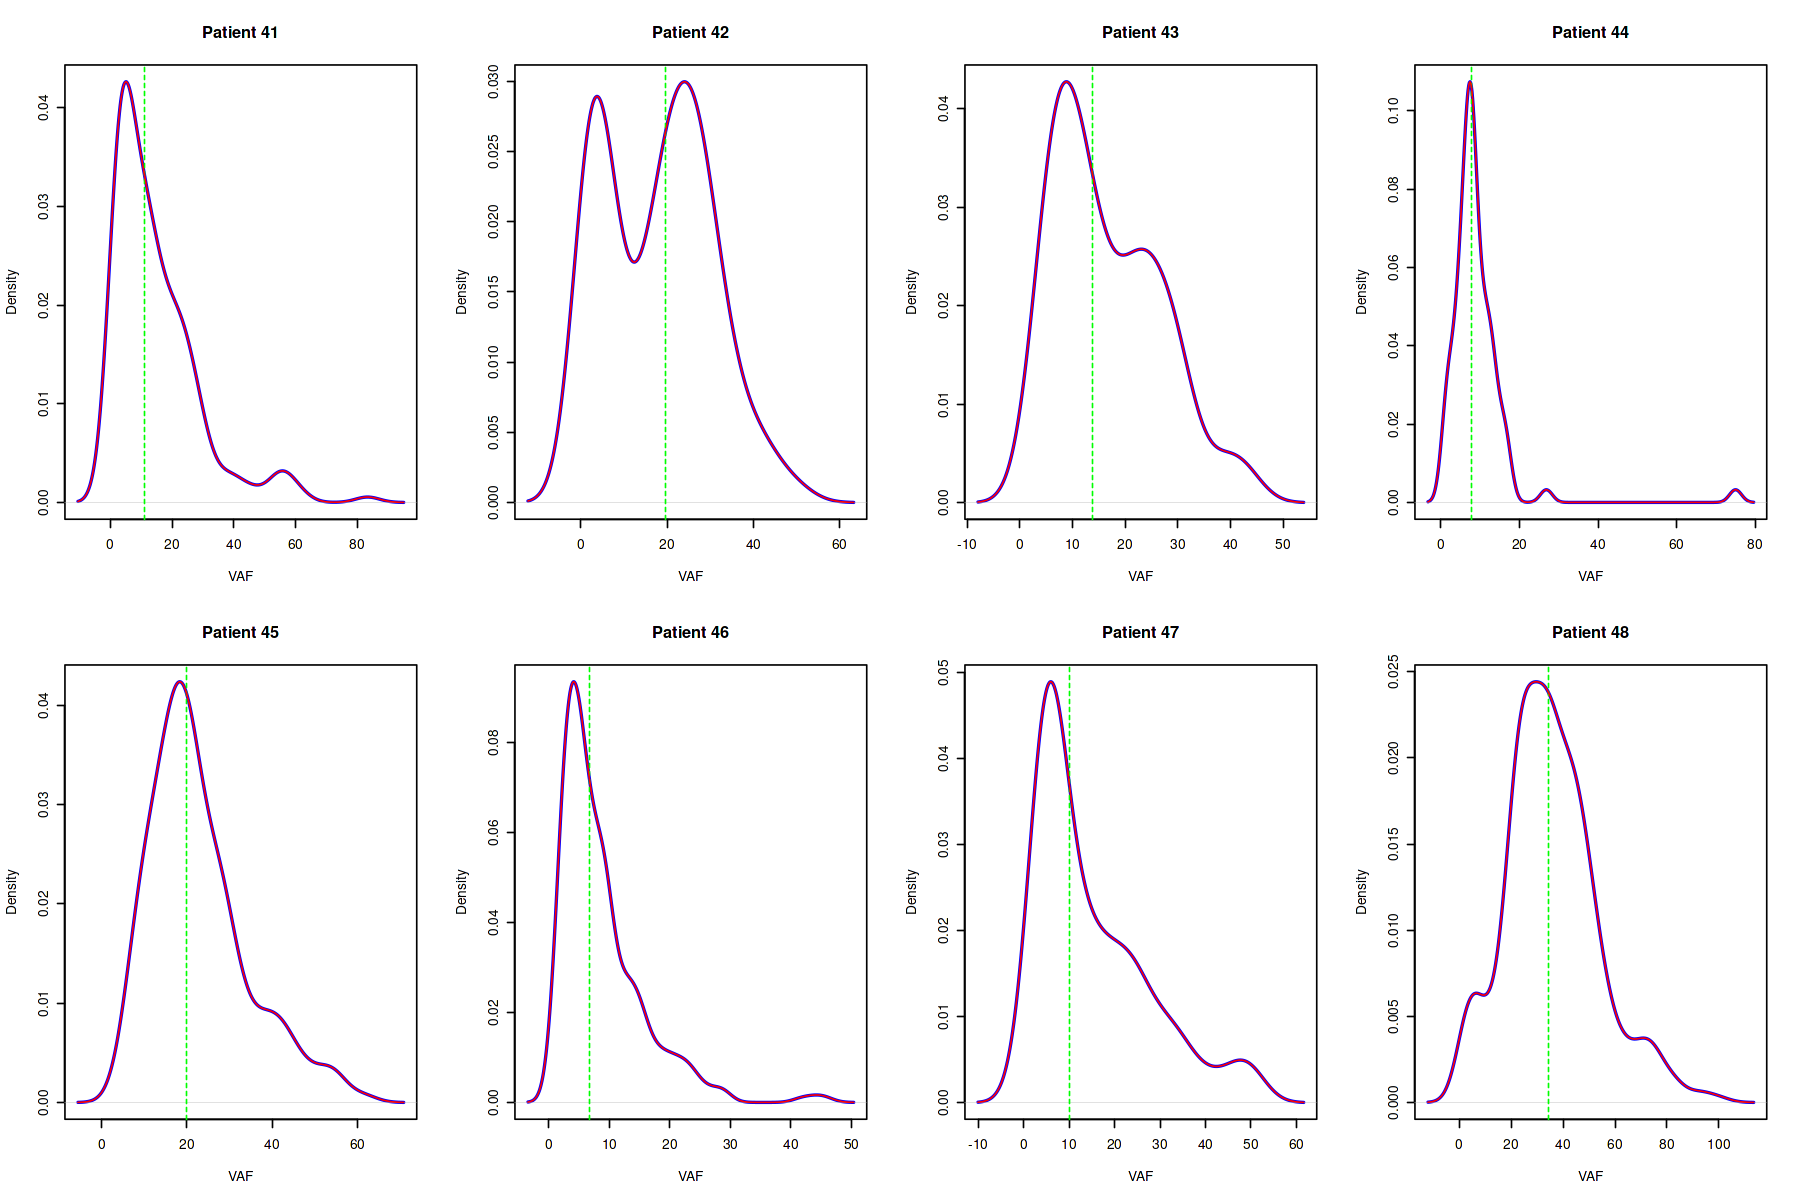

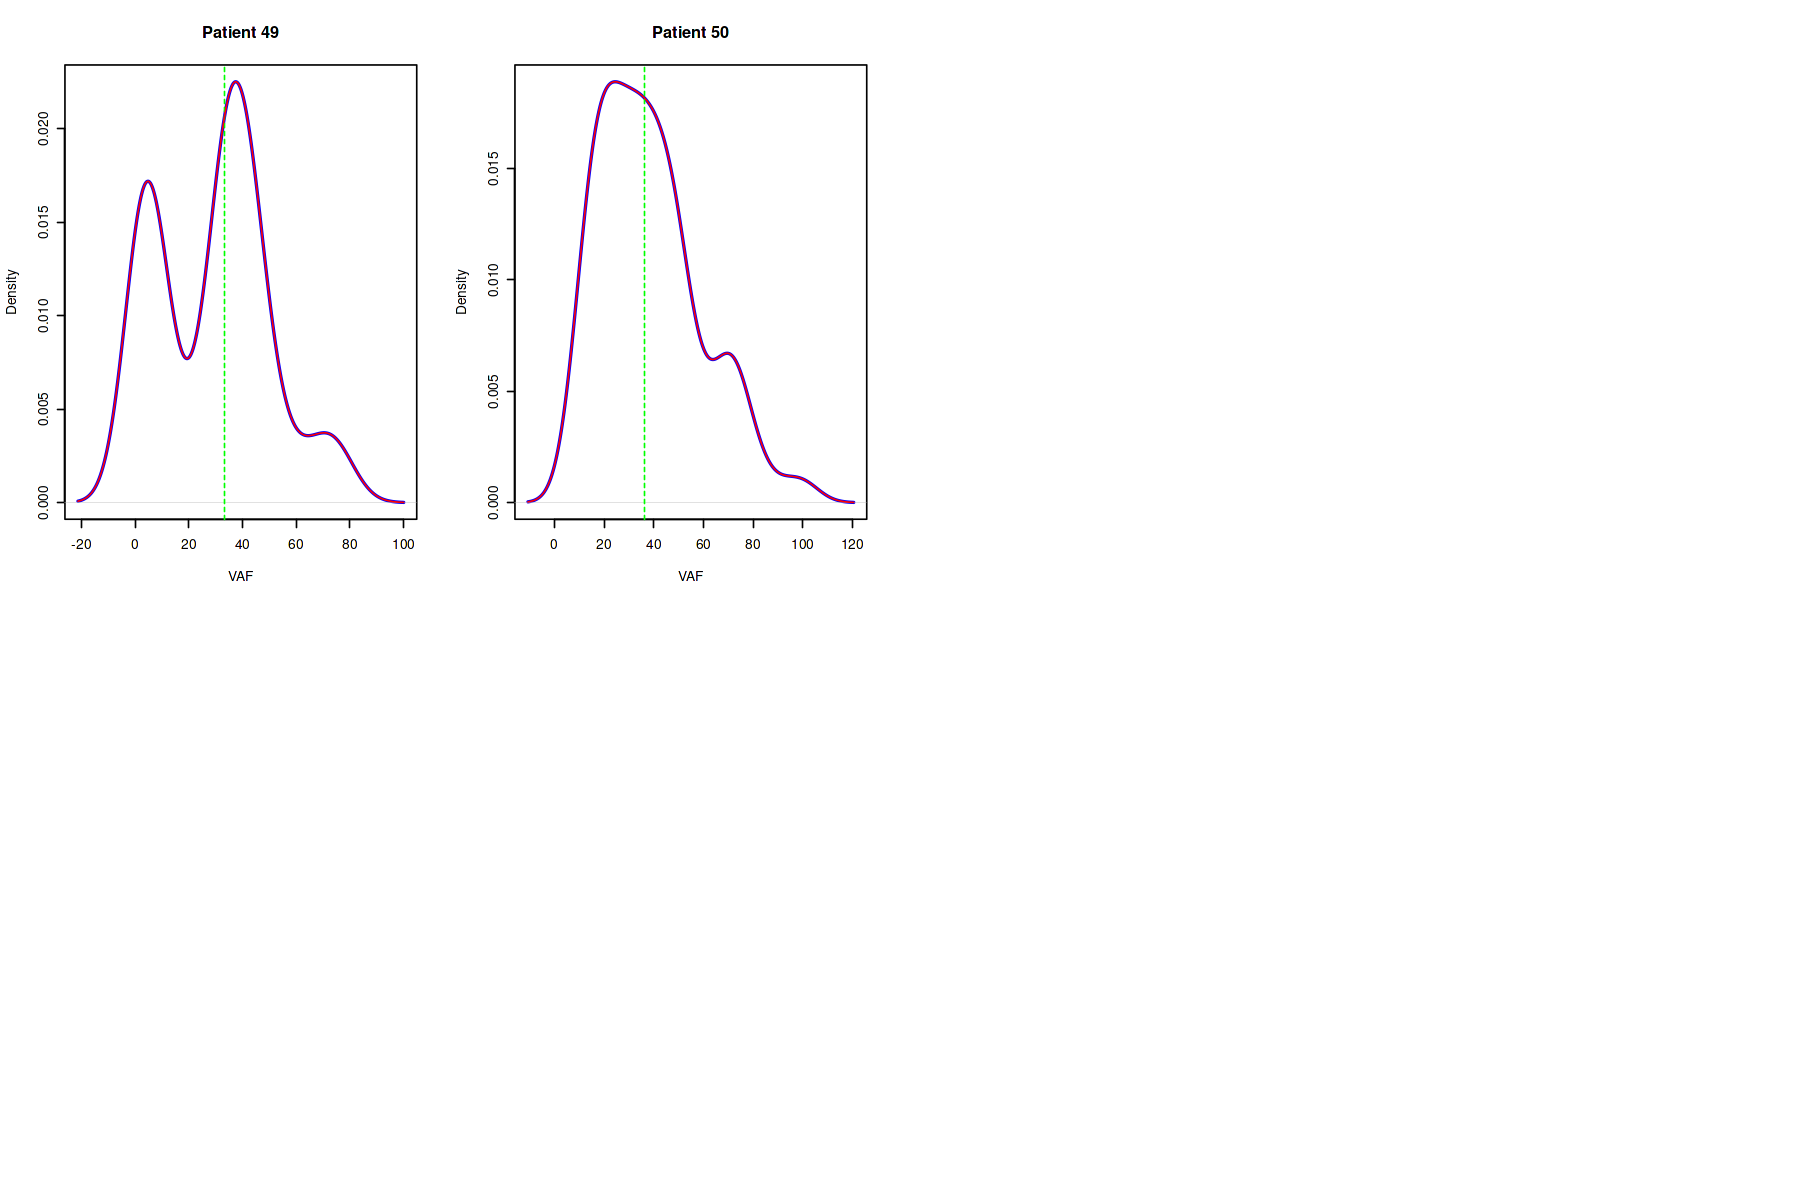

In [15]:
# 3. Density plot. Calculate VAF for each patient.
#    VAF = (number of mutant copies / (number of wild-type copies + number of mutant copies)) * 100. 
#    Plot Density Curve for the same.

  # Calculate VAF for each mutation
merged_data.1$VAF <- (as.numeric(merged_data.1$t_alt_count) / (as.numeric(merged_data.1$t_ref_count) + as.numeric(merged_data.1$t_alt_count))) * 100

  # Subset data for each patient
patient_data <- list()
patient_identifiers = unique(merged_data.1$Tumor_Sample_Barcode)

  # Loop through each patient
for ( i in patient_identifiers) {
 each = subset(merged_data.1, Tumor_Sample_Barcode == i)
 patient_data[[i]] = each
}

options(repr.plot.width = 15, repr.plot.height = 10)
#par(mar = c(0.5, 1, 5, 1) + 0.1) 

graph_size1 = par(mfrow = c(2,4))
  # Loop through each patient's data
for (i in seq_along(patient_data)) {
    
  current_patient_data = patient_data[[i]]
  
  # Plot the density of nonsynonymous mutations per megabase
  density_values = density(current_patient_data$VAF)
  
  plot(density_values, main = paste("Patient", i),
       xlab = "VAF", col = "blue", lwd = 2)
  
  # Add vertical line at the median
  median_value = median(current_patient_data$VAF)
  abline(v = median_value, col = "green", lty = 2)
  lines(density_values, col = "red")
  #legend("topright", legend = c("Density Curve", "Median"), col = c("red", "green"), lty = c(1, 2))
  

  }
par(graph_size1)
## Observations
# a. Probability density curves of VAFs (Variant allele frequency) are plotted for each patient in the study.
# b. The green vertical line represent the median density for each patient.
# c. The shape of the each density plot provides the skewness of distribution. Wider curves show more variability.
# Patient 49 was oberserved to have the highest median density.

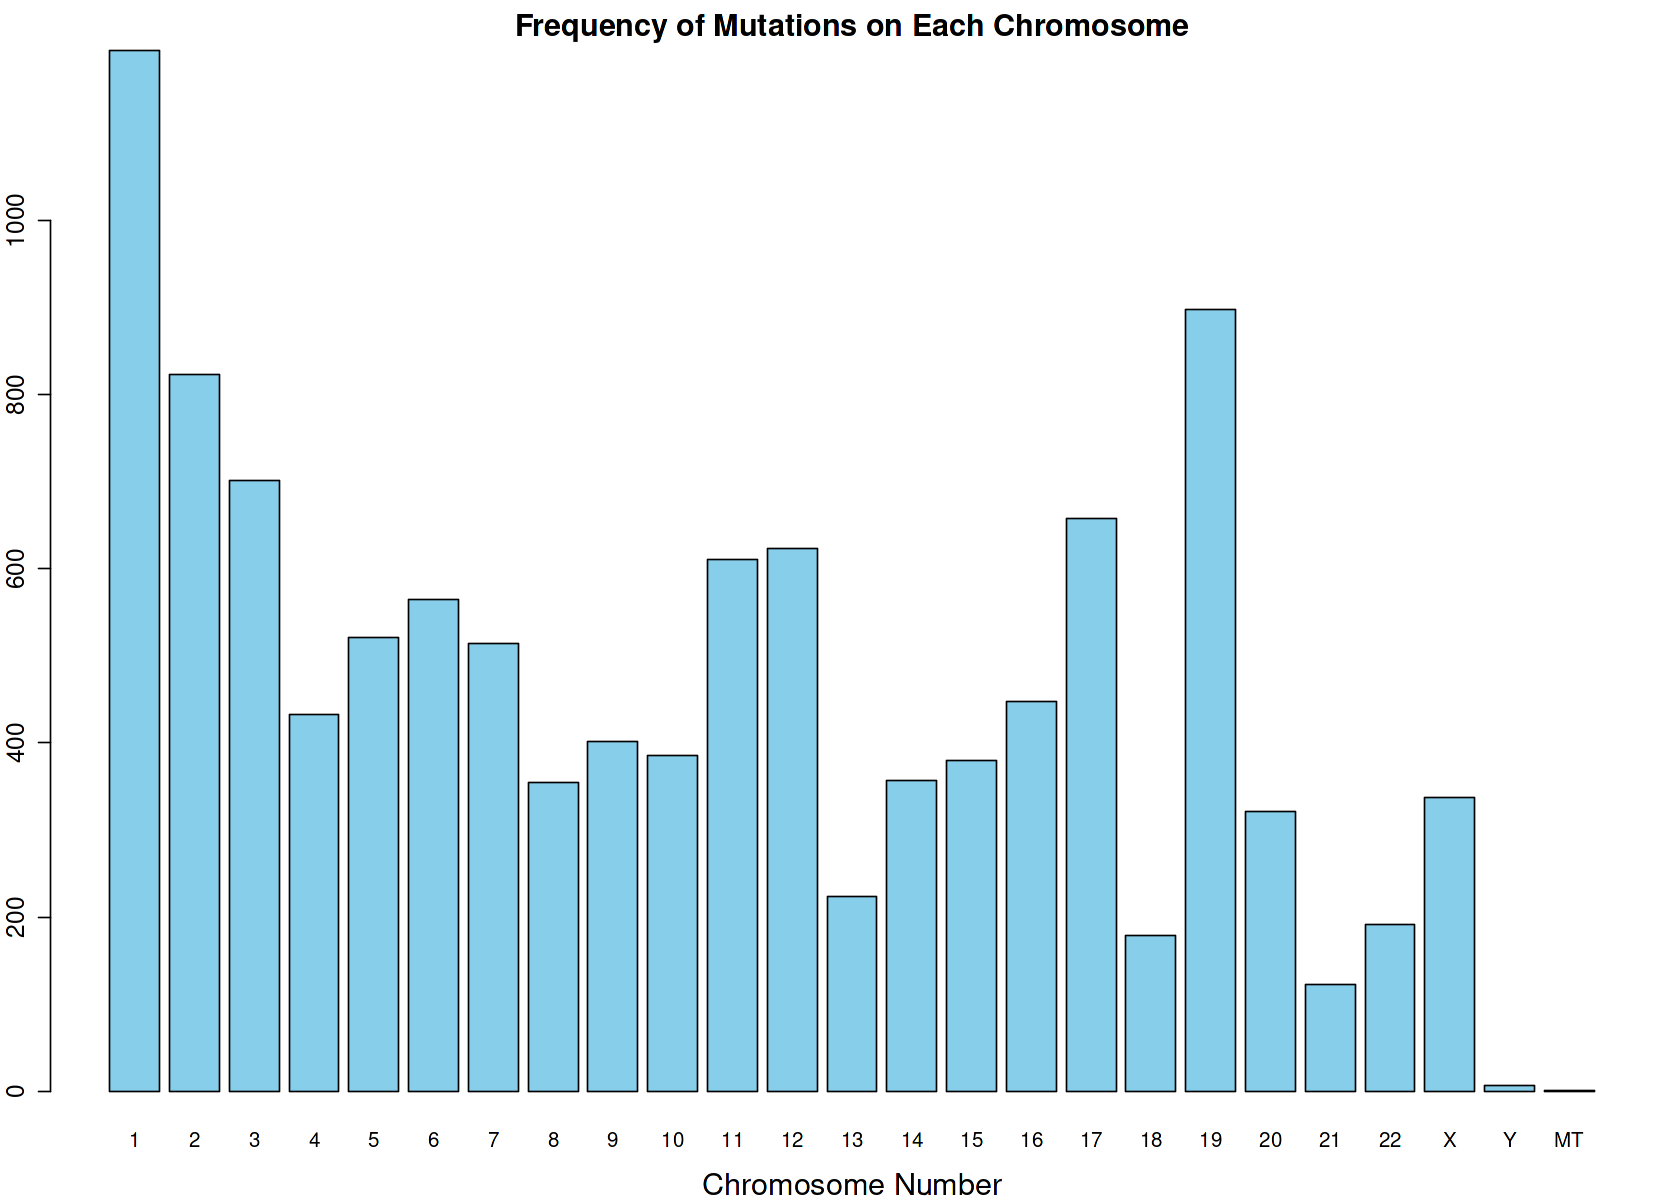

In [16]:
# 4. histogram / barplot. Frequency of Mutations on each chromosome.
# Count the frequency of mutations on each chromosome
chromosome_counts <- table(merged_data$Chromosome)
ordered_chromosomes <- c(1:22, "X", "Y", "MT")
chromosome_counts <- chromosome_counts[match(ordered_chromosomes, names(chromosome_counts))]

# Plot the bar plot
options(repr.plot.width = 14, repr.plot.height = 10)
par(mar = c(4, 2, 2, 1) + 0.1)
barplot(chromosome_counts, names.arg = names(chromosome_counts),
        col = "skyblue", main = "Frequency of Mutations on Each Chromosome",
        xlab = "Chromosome Number", ylab = "Mutation Frequency",
        cex.axis = 1.2, cex.main = 1.5, cex.lab = 1.5)


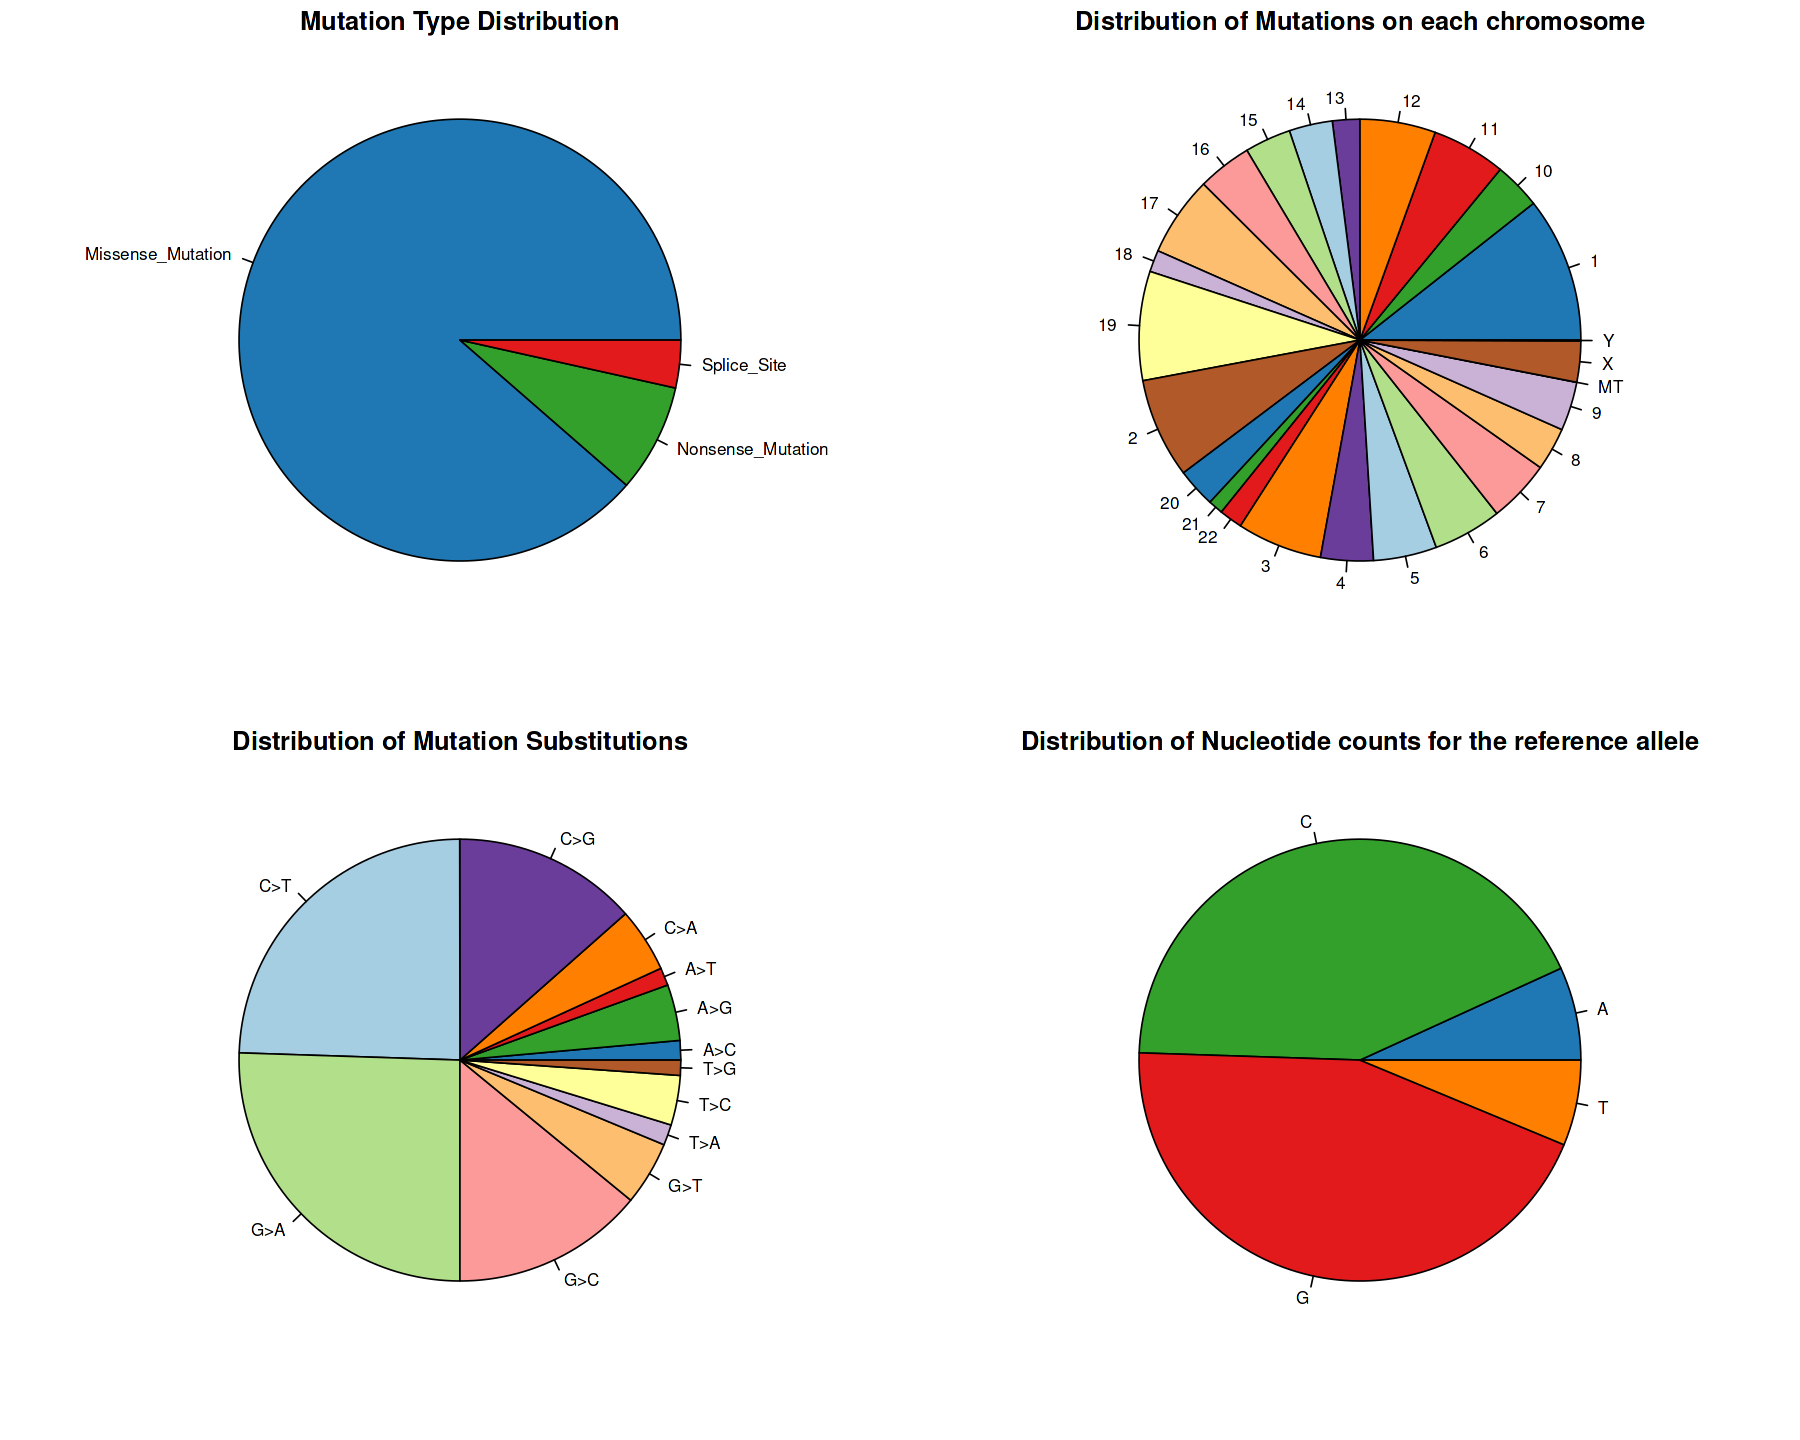

In [17]:
# 5. Multiple Overall Pie charts.

options(repr.plot.width = 15, repr.plot.height = 12)
par(mar = c(4, 2, 2, 1) + 0.1)
graph_size = par(mfrow = c(2,2))

pie(table(merged_data.1$Variant_Classification), 
    main = "Mutation Type Distribution",
    col = my_colors, cex.main = 1.5)

pie(table(merged_data$Chromosome),
    main = "Distribution of Mutations on each chromosome", 
    col = my_colors, cex.main = 1.5)

pie(table(merged_data.1$comparison_column),
    main = "Distribution of Mutation Substitutions",
    col = my_colors, cex.main = 1.5)

pie(table(merged_data.1$Reference_Allele),
    main = "Distribution of Nucleotide counts for the reference allele",
    col = my_colors, cex.main = 1.5)

par(graph_size)

### Suggestion for Expansions.

a. Using time variable for mutations in patients, A kaplan Miere curve can be plotted for comparing progression-free survival for responders and non-responders.

b. If CNVs present, we could compare CNVs (total size, average length and gene counts) between Responders and Non-responders.
Could also correlate CNV total length v/s Non-synonymous mutation count, etc.
